<a href="https://colab.research.google.com/github/DhruvaBansal00/ConfidentMT/blob/master/LM_Thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install fairseq sacrebleu sentencepiece

  Using cached https://files.pythonhosted.org/packages/67/bf/de299e082e7af010d35162cb9a185dc6c17db71624590f2f379aeb2519ff/fairseq-0.9.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/98/f6/21311ebe1af3e2e6d959cc5ce69e09cae6b6267bbd6db294fcd8744316f6/sacrebleu-1.4.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/98/2c/8df20f3ac6c22ac224fff307ebc102818206c53fc454ecd37d8ac2060df5/sentencepiece-0.1.86-cp36-cp36m-manylinux1_x86_64.whl
     |████████████████████████████████| 17.1MB 1.3MB/s 
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=2035386 sha256=6144c9c46516f376abd68a3cbc8f1775c7fe66c660c6c4b2a1846aeb837ee654
  Stored in directory: /root/.cache/pip/wheels/37/3e/1b/0fa30695dcba41e4b0088067fa40f3328d1e8ee78c22cd4766
Successfully built fairseq


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls
%cd drive/My Drive/ConfidentMachineTranslation/flores
!ls
!pwd

drive  sample_data
/content/drive/.shortcut-targets-by-id/1viBwZM7BIiD8O4LeU-9UQXyV82oTWqh6/ConfidentMachineTranslation/flores
 analysis	   data-bin		        LM_Thresholding.ipynb
 Analysis	   Ensembles		        NCD_Analysis.ipynb
 backward_models   Ensembling		        noisychannel
 checkpoints	   FLORES.ipynb		        NoisyChannel.ipynb
 configs	   language_models	        Resources
 data		  'LM_Thresholding (1).ipynb'   scripts
/content/drive/.shortcut-targets-by-id/1viBwZM7BIiD8O4LeU-9UQXyV82oTWqh6/ConfidentMachineTranslation/flores


In [0]:
from statistics import mean, median 

bleu_res = open("analysis/testSet_BLEU.txt", "r")
NMT_ground_truth = open("analysis/ground_truth_sentences.txt", "w")
NMT_output = open("analysis/translated_sentences.txt", "w")
Sentence_stats = open("analysis/logprob_statistics.txt", "w")

for line in bleu_res:
    if line.startswith("H-"):
        NMT_output.write(line.split("	")[2])
    elif line.startswith("T-"):
        NMT_ground_truth.write(line.split("	")[1])
    elif line.startswith("P-"):
        scores = [float(i) for i in line.split("\t")[1].split(" ")]
        Sentence_stats.write(str(mean(scores))+" "+str(min(scores))+" "+str(median(scores))+" "+str(max(scores))+"\n")

NMT_ground_truth.close()
NMT_output.close()
Sentence_stats.close()

In [0]:
!fairseq-score --sys analysis/translated_sentences.txt --ref analysis/ground_truth_sentences.txt --sentence-bleu > analysis/scores.txt

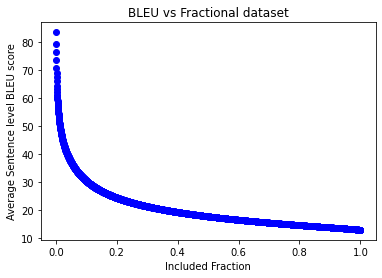

AUC for incuded fraction: 20.396594958586256


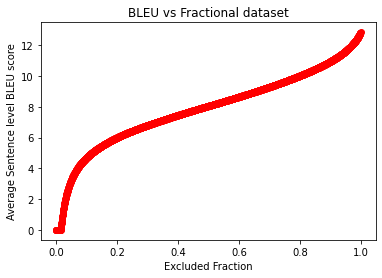

AUC for excluded fraction: 7.857580585056041


In [0]:
from itertools import zip_longest
import matplotlib.pyplot as plt
from sklearn.metrics import auc

class Translation:
    def __init__ (self, ref, out, score):
        self.reference = ref
        self.translation = out
        self.score = score
    def __repr__(self):
        return str(self.score)

def compute_excluded_included_score (translations, split_index):
    included_sum = 0
    excluded_sum = 0

    for index in range(0, len(translations)):
        if index < split_index:
            excluded_sum += translations[index].score
        else:
            included_sum += translations[index].score
    included_score = 0 if split_index == len(translations) - 1 else included_sum/(len(translations) - split_index)
    excluded_score = 0 if split_index == 0 else excluded_sum/(split_index)
    return excluded_score, included_score

NMT_ground_truth = open("analysis/ground_truth_sentences.txt", "r")
NMT_output = open("analysis/translated_sentences.txt", "r")
Sentence_bleu = open("analysis/scores.txt", "r")

files = [NMT_ground_truth, NMT_output, Sentence_bleu]
next(Sentence_bleu)
translations = []

for lines in zip_longest(*files, fillvalue=''):
    reference, translation, score = lines
    score = float(score.split("BLEU4 = ")[1].split(",")[0])
    translations.append(Translation(reference, translation, score))

translations.sort(key=lambda x: x.score, reverse=False)

inclusion_scores = []
exclusion_scores = []
fraction_included = []
fraction_excluded = []

include_graph = True

for split_index in range(0, len(translations)-1):
    # if (translations[split_index].score == 0.0):
    #     print(translations[split_index].reference)
    #     print(translations[split_index].translation)
    exclusion, inclusion = compute_excluded_included_score(translations, split_index)
    inclusion_scores.append(inclusion)
    exclusion_scores.append(exclusion)
    fraction_included.append((len(translations) - split_index)/len(translations))
    fraction_excluded.append(split_index/len(translations))

  
plt.scatter(fraction_included, inclusion_scores, color= "blue")
plt.xlabel('Included Fraction') 
plt.ylabel('Average Sentence level BLEU score') 
plt.title('BLEU vs Fractional dataset') 
plt.show() 

print('AUC for incuded fraction: {}'.format(auc(fraction_included, inclusion_scores)))

plt.scatter(fraction_excluded, exclusion_scores, color= "red")
plt.xlabel('Excluded Fraction') 
plt.ylabel('Average Sentence level BLEU score') 
plt.title('BLEU vs Fractional dataset') 
plt.show()  

print('AUC for excluded fraction: {}'.format(auc(fraction_excluded, exclusion_scores)))

NMT_ground_truth.close()
NMT_output.close()
Sentence_bleu.close()

In [0]:
from itertools import zip_longest
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from numpy import arange
import subprocess
import random
import numpy as np


class Translation:
    def __init__ (self, ref, out, score):
        self.reference = ref
        self.translation = out
        self.score = score
    def __repr__(self):
        return str(self.score)

def compute_excluded_included_score (translations, split_index):
    temporary_reference_inclusion = open("analysis/temporary_reference_inclusion.txt", "w")
    temporary_output_inclusion = open("analysis/temporary_output_inclusion.txt", "w")

    temporary_reference_exclusion = open("analysis/temporary_reference_exclusion.txt", "w")
    temporary_output_exclusion = open("analysis/temporary_output_exclusion.txt", "w")

    for i in range(len(translations)):
        if i < split_index:
            temporary_reference_exclusion.write(translations[i].reference)
            temporary_output_exclusion.write(translations[i].translation)
        else:
            temporary_reference_inclusion.write(translations[i].reference)
            temporary_output_inclusion.write(translations[i].translation)

    temporary_reference_inclusion.close()
    temporary_output_inclusion.close()
    temporary_reference_exclusion.close()
    temporary_output_exclusion.close()

    !fairseq-score --sys analysis/temporary_output_inclusion.txt --ref analysis/temporary_reference_inclusion.txt --sacrebleu > analysis/inclusion_result.txt
    !fairseq-score --sys analysis/temporary_output_exclusion.txt --ref analysis/temporary_reference_exclusion.txt --sacrebleu > analysis/exclusion_result.txt

    temporary_inclusion_result = open("analysis/inclusion_result.txt")
    temporary_exclusion_result = open("analysis/exclusion_result.txt")
    inclusion_result_string = [line for line in temporary_inclusion_result][1].split(" ")[2]
    exclusion_result_string = [line for line in temporary_exclusion_result][1].split(" ")[2]

    return float(exclusion_result_string), float(inclusion_result_string)


NMT_ground_truth = open("analysis/ground_truth_sentences.txt", "r")
NMT_output = open("analysis/translated_sentences.txt", "r")
Sentence_stats = open("analysis/logprob_statistics.txt", "r")
Sentence_bleu = open("analysis/scores.txt", "r")

next(Sentence_bleu)
files = [NMT_ground_truth, NMT_output, Sentence_stats, Sentence_bleu]
translations = []

for lines in zip_longest(*files, fillvalue=''):
    reference, translation, stats, sentence_bleu = lines
    sentence_bleu = float(sentence_bleu.split("BLEU4 = ")[1].split(",")[0])
    stats = [float(i) for i in stats.strip("\n").split(" ")]
    stats.append(sentence_bleu)
    translations.append(Translation(reference, translation, stats))

stats_for_thresholding = [0,1,2,3,4] #average per token, min, median, max, sentence_bleu
num_to_thresh = {0:"Average logprob thresholding", 1: "Min logprob thresholding", 2:"Median logprob thresholding", 3:"Max logprob thresholding", 4:"Sentence-level BLEU thresholding"}
all_inclusion_scores = []
all_fractions_included = []

for stat in stats_for_thresholding:
    translations.sort(key=lambda x: x.score[stat], reverse=False)
    # print("Worst reference: " +translations[0].reference+" Worst translation: "+translations[0].translation)
    thresholds = []


    ##25 good thresholds for each case
    if stat == 0:
        thresholds = np.linspace(-1.5, 0, 25).tolist()
    elif stat == 1:
        thresholds = np.linspace(-3.5, 0, 25).tolist()
    elif stat == 2:
        thresholds = np.linspace(-1.5, 0, 25).tolist()
    elif stat == 3:
        thresholds = np.linspace(-0.1, 0, 25).tolist() 
    elif stat == 4:
        thresholds = np.linspace(0, 70, 25).tolist()

    inclusion_scores = []
    exclusion_scores = []
    fraction_included = []
    fraction_excluded = []

    for threshold in thresholds:
        split_index = 1 ## We always start at 1% so that the exclusion set is never empty. 
        while split_index < 0.99*len(translations) and translations[split_index].score[stat] < threshold:  ##0.99*len(translations) - to make sure the inclusion set always has a good number of examples
            split_index += 1
        exclusion, inclusion = compute_excluded_included_score(translations, split_index)
        inclusion_scores.append(inclusion)
        exclusion_scores.append(exclusion)
        fraction_included.append((len(translations) - split_index)/len(translations))
        fraction_excluded.append(split_index/len(translations))
    
    all_inclusion_scores.append(inclusion_scores)
    all_fractions_included.append(fraction_included)

In [0]:
#Read LM_Scores file into an ordered list of floats
lm_scores = open("noisychannel/rerank_data/ncd_without_ensembling/nbest_5_subset_test_fw_name_ne-en_shard_0_of_1/lm_scores", "r")
lm_scores_list = []
for line in lm_scores:
  lm_scores_list.append(float(line[:-1]))
print("min val: ", min(lm_scores_list))
print("max val: ", max(lm_scores_list))
lower_bound = min(lm_scores_list)
upper_bound = max(lm_scores_list)

min val:  -454.796458
max val:  -46.785695


In [0]:
from itertools import zip_longest

class Translation:
    def __init__ (self, ref, out):
        self.reference = ref
        self.translation = out

def get_sentence_pairs():
  NCD_ground_truth = open("noisychannel/rerank_data/ncd_without_ensembling/nbest_5_subset_test_fw_name_ne-en_shard_0_of_1/matched_targets", "r")
  NCD_output = open("noisychannel/rerank_data/ncd_without_ensembling/nbest_5_subset_test_fw_name_ne-en_shard_0_of_1/matched_hypos", "r")
  files = [NCD_ground_truth, NCD_output]
  translations = []
  for lines in zip_longest(*files, fillvalue=''):
    reference, translation = lines
    translations.append(Translation(reference, translation))
  return translations

def compute_excluded_included_score(translations, thresh):
  temporary_reference_inclusion = open("analysis/temporary_reference_inclusion.txt", "w")
  temporary_output_inclusion = open("analysis/temporary_output_inclusion.txt", "w")

  temporary_reference_exclusion = open("analysis/temporary_reference_exclusion.txt", "w")
  temporary_output_exclusion = open("analysis/temporary_output_exclusion.txt", "w")

  num_exc = 0
  for i, lm in enumerate(lm_scores_list):
    if lm < thresh:
      temporary_reference_exclusion.write(translations[i].reference)
      temporary_output_exclusion.write(translations[i].translation)
      num_exc += 1
    else:
      temporary_reference_inclusion.write(translations[i].reference)
      temporary_output_inclusion.write(translations[i].translation)
  temporary_reference_inclusion.close()
  temporary_output_inclusion.close()
  temporary_reference_exclusion.close()
  temporary_output_exclusion.close()

  !fairseq-score --sys analysis/temporary_output_inclusion.txt --ref analysis/temporary_reference_inclusion.txt --sacrebleu > analysis/inclusion_result.txt
  !fairseq-score --sys analysis/temporary_output_exclusion.txt --ref analysis/temporary_reference_exclusion.txt --sacrebleu > analysis/exclusion_result.txt

  temporary_inclusion_result = open("analysis/inclusion_result.txt")
  temporary_exclusion_result = open("analysis/exclusion_result.txt")
  inclusion_result_string = [line for line in temporary_inclusion_result]
  if len(inclusion_result_string) > 1:
    inclusion_result_string = float(inclusion_result_string[1].split(" ")[2])
  else:
    inclusion_result_string = float(0)
  exclusion_result_string = [line for line in temporary_exclusion_result]
  if len(exclusion_result_string) > 1:
    exclusion_result_string = float(exclusion_result_string[1].split(" ")[2])
  else:
    exclusion_result_string = float(0)
  return exclusion_result_string, inclusion_result_string, num_exc


25
BLEU SCORES AT LM THRESHOLD VALUE:  -453.796458
Excluded BLEU:  1.53
Included BLEU:  7.92 

BLEU SCORES AT LM THRESHOLD VALUE:  -437.55602747999995
Excluded BLEU:  0.78
Included BLEU:  7.93 

BLEU SCORES AT LM THRESHOLD VALUE:  -421.31559695999994
Excluded BLEU:  0.64
Included BLEU:  7.93 

BLEU SCORES AT LM THRESHOLD VALUE:  -405.0751664399999
Excluded BLEU:  1.0
Included BLEU:  7.93 

BLEU SCORES AT LM THRESHOLD VALUE:  -388.8347359199999
Excluded BLEU:  0.88
Included BLEU:  7.94 

BLEU SCORES AT LM THRESHOLD VALUE:  -372.5943053999999
Excluded BLEU:  0.88
Included BLEU:  7.94 

BLEU SCORES AT LM THRESHOLD VALUE:  -356.35387487999986
Excluded BLEU:  1.05
Included BLEU:  7.94 

BLEU SCORES AT LM THRESHOLD VALUE:  -340.11344435999985
Excluded BLEU:  4.14
Included BLEU:  7.93 

BLEU SCORES AT LM THRESHOLD VALUE:  -323.8730138399998
Excluded BLEU:  3.96
Included BLEU:  7.94 

BLEU SCORES AT LM THRESHOLD VALUE:  -307.6325833199998
Excluded BLEU:  4.9
Included BLEU:  7.95 

BLEU SCORES 

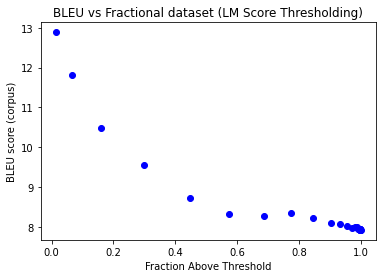

AUC for incuded fraction: 9.011712522045855


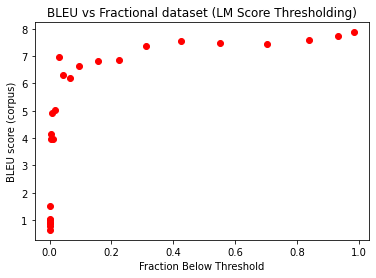

AUC for excluded fraction: 7.129320987654322


In [0]:
from numpy import arange
import matplotlib.pyplot as plt
from sklearn.metrics import auc

translations = get_sentence_pairs()
thresholds = [i for i in arange(lower_bound+1, upper_bound-1, (upper_bound-lower_bound-2)/25)]
print(len(thresholds))

inclusion_scores = []
exclusion_scores = []
fraction_included = []
fraction_excluded = []

for thresh in thresholds:
  exc, inc, num_exc = compute_excluded_included_score(translations, thresh)
  print("BLEU SCORES AT LM THRESHOLD VALUE: ", thresh)
  print("Excluded BLEU: ", exc)
  print("Included BLEU: ", inc,"\n")
  inclusion_scores.append(inc)
  exclusion_scores.append(exc)
  fraction_included.append((len(translations) - num_exc)/len(translations))
  fraction_excluded.append(num_exc/len(translations))
all_inclusion_scores.append(inclusion_scores)
all_fractions_included.append(fraction_included)
#########################   PLOTING   ################################
plt.scatter(fraction_included, inclusion_scores, color= "blue")
plt.xlabel('Fraction Above Threshold') 
plt.ylabel('BLEU score (corpus)') 
plt.title('BLEU vs Fractional dataset (LM Score Thresholding)') 
plt.show() 

print('AUC for incuded fraction: {}'.format(auc(fraction_included, inclusion_scores)))

plt.scatter(fraction_excluded, exclusion_scores, color= "red")
plt.xlabel('Fraction Below Threshold') 
plt.ylabel('BLEU score (corpus)') 
plt.title('BLEU vs Fractional dataset (LM Score Thresholding)') 
plt.show()  

print('AUC for excluded fraction: {}'.format(auc(fraction_excluded, exclusion_scores)))
####################################################################


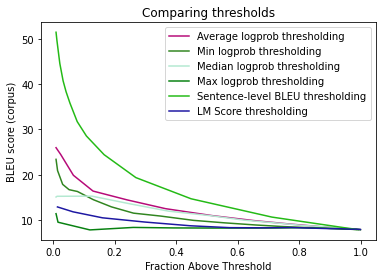

In [0]:
num_to_thresh = {0:"Average logprob thresholding", 1: "Min logprob thresholding", 2:"Median logprob thresholding", 3:"Max logprob thresholding", 4:"Sentence-level BLEU thresholding", 5:"LM Score thresholding"}
plt.xlabel('Fraction Above Threshold') 
plt.ylabel('BLEU score (corpus)') 
plt.title('Comparing thresholds') 
for i in range(len(all_inclusion_scores)):
    r = random.random()
    b = random.random()
    g = random.random()
    c = (r, g, b)
    plt.plot(all_fractions_included[i], all_inclusion_scores[i], label = num_to_thresh[i], color=c)

plt.legend(loc="upper right")
plt.show()

NMT_ground_truth.close()
NMT_output.close()
Sentence_bleu.close()